## Tutorial 3: Bayesian Mixture Models and Gibbs sampling

### Exercise 1: Categorical Mixture Model (CMM)

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
import scipy.special

import math

import gensim
from wordcloud import WordCloud, STOPWORDS

##### Load and pre-process the data

In [2]:
df = pd.read_csv('tweets_cleaned.csv')
df.drop_duplicates(subset="tweet", inplace=True)  # drop duplicates tweets
df['tokens'] = df['tokens'].apply(literal_eval)  # transform the string into a list of tokens
X_tokens = list(df['tokens'].values)

In [3]:
print('Columns: {}\n'.format(' | '.join(df.columns.values)))

print('Tweet:\n{}'.format(df.loc[1, 'tweet']))
print('Tweet cleaned:\n{}'.format(df.loc[1, 'tweets_clean']))
print('Tweet tokens:\n{}'.format(X_tokens[1]))

Columns: tweet_id | timestamp | user_id | tweet | tweets_clean | tokens

Tweet:
OSINT people - please retweet, if possible. My friend is looking for women involved in OSINT. https://twitter.com/manisha_bot/status/1181594280336531457 …
Tweet cleaned:
osint people   please retweet  if possible  my friend is looking for women involved in osint
Tweet tokens:
['osint', 'peopl', 'retweet', 'possibl', 'friend', 'look', 'woman', 'involv', 'osint']


##### Create the dictionary

In [4]:
I = 120  # hyperparameter: number of different words to keep
K = 5  # hyperparameter: number of topics

In [5]:
dictionary = gensim.corpora.Dictionary(X_tokens)
print(dictionary)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=I)
print(dictionary)

Dictionary(12243 unique tokens: ['collin', 'cum', 'domin', 'phil', 'room']...)
Dictionary(120 unique tokens: ['look', 'peopl', 'woman', 'love', 'work']...)


##### Create Bag of Words (BoW)

In [6]:
X_bow = list()
keep_tweet = list()
for tweet in X_tokens:
    tweet_bow = dictionary.doc2bow(tweet)
    if len(tweet_bow) > 1:
        X_bow.append(tweet_bow)
        keep_tweet.append(True)
    else:
        keep_tweet.append(False)

df_data = df[keep_tweet]
N = len(df_data)

##### Create the matrix

In [7]:
X_matrix = np.zeros([N, I])
for i, doc_bow in enumerate(X_bow):
    word_list = list()
    for word in doc_bow:
        X_matrix[i, word[0]] = word[1]
X_matrix.shape

(5568, 120)

#### Useful functions

In [8]:
# log sum exponential trick
def compute_lset(ns):
    return scipy.special.logsumexp(ns)

# initialize parameters
def initialize_parameters(N, K, alpha, gamma):
    pi_vector = np.random.dirichlet(alpha, size=1).flatten()  # [K, ]
    Z_matrix = np.random.multinomial(n=1, pvals=pi_vector, size=N)  # One hot encoding NxK
    theta_matrix = np.random.dirichlet(gamma, size=K)  # [K, I]
    return pi_vector, theta_matrix, Z_matrix

#### 1.4) Implement the log-likelihood of the model

In [9]:
def log_likelihood_X(X, Z, theta_matrix):
    log_lik = np.sum(Z * (X_matrix @ np.log(theta_matrix).T))
    return log_lik

#### 1.5) Implement Algorithm 1, i.e. the posterior distributions obtained in point 1) and fill in the function *fit_no_collapsed_Gibbs*. Then, train the algorithm for 80 iterations with a burn in period τburn−in = 20 iterations. 

In [10]:
def pi_Z(Z, alpha):
    m_k = np.sum(Z, axis=0)
    alpha_p = alpha + m_k
    pi_sample = np.random.dirichlet(alpha_p, size=1).flatten()
    return pi_sample

def thetak_XZ(X, Z, k, gamma):
    def gammak_p(z_matrix, x_matrix, k, gamma):
        z_k = (z_matrix[:, [k]].T == 1).flatten()
        c_k = np.sum(x_matrix[z_k, :], axis=0)
        gamma_p = gamma + c_k
        return gamma_p
    gamma_p = gammak_p(Z, X, k, gamma)
    thetak_sample = np.random.dirichlet(gamma_p, size=1).flatten()
    return thetak_sample

def Z_pi_theta_xn(X, pi_vector, theta_matrix):
    N, I = X.shape
    K = theta_matrix.shape[0]

    log_theta_matrix = np.log(theta_matrix)
    log_pi_vector = np.log(pi_vector)

    last_term = np.zeros([N, 1])
    last_term2 = X @ log_theta_matrix.T
    ns = last_term2 + np.tile(log_pi_vector, [N, 1])  # [N, K]
    for i in range(N):
        last_term[i] = compute_lset(ns[i, :])

    last_term = np.tile(last_term, [1, K])
    log_r_matrix = np.tile(log_pi_vector, [N, 1]) + last_term2 - last_term
    r_matrix = np.exp(log_r_matrix)

    Z_probs = np.clip(r_matrix, 1e-250, None)
    def f(probs):
        K = len(probs)
        a = np.zeros(K, dtype=np.int64)
        q = np.random.choice(K, size=1, replace=True, p=probs)
        a[q] = 1
        return a
    Z_sample = np.apply_along_axis(f, 1, Z_probs)
    return  Z_probs, Z_sample

In [11]:
# Show the evolution of the log-likelihood per iteration.
# Obtain the MAP estimate of the cluster assignments computed after τburn-in.

def fit_no_collapsed_Gibbs(X, K, alpha, gamma, burn_in, n_iters):
    N, I = X.shape
    '''Initialize parameters'''
    pi_vector, theta_matrix, Z_matrix = initialize_parameters(N, K, alpha, gamma)
    z_map = np.zeros([N, K])

    log_x_list = []
    for it in range(n_iters):
        '''Update parameters'''
        pi_vector = pi_Z(Z_matrix, alpha)
        for k in range(K):
            theta_matrix[k, :] = thetak_XZ(X, Z_matrix, k, gamma)
        Z_probs, Z_matrix  = Z_pi_theta_xn(X, pi_vector, theta_matrix)
        '''Check log-likelihood'''
        log_lik_it = log_likelihood_X(X, Z_matrix, theta_matrix)
        log_x_list.append(log_lik_it)
        
        print('ITER: {} | log_lik: {}'.format(str(it), log_lik_it))
        
        if it >= burn_in: 
            z_map += Z_matrix
            
    Zk = np.argmax(z_map, axis=-1)
    z_map = np.zeros([N, K])
    for i in range(N):
        z_map[i, Zk[i]] = 1.
    
    return pi_vector, theta_matrix, Z_matrix, z_map, log_x_list

In [12]:
%%time
np.random.seed(1234)

alpha = 1*np.ones(K)
gamma = np.ones(I)

pi_vector, theta_matrix, Z_matrix, z_map, log_x_list = fit_no_collapsed_Gibbs(X_matrix, K, alpha, gamma, 
                                                                              burn_in=20, n_iters=80)

ITER: 0 | log_lik: -102556.70707606588
ITER: 1 | log_lik: -101445.8881058007
ITER: 2 | log_lik: -99603.80674701346
ITER: 3 | log_lik: -98438.38578173114
ITER: 4 | log_lik: -97465.26552522031
ITER: 5 | log_lik: -96852.38884761161
ITER: 6 | log_lik: -96385.03897160769
ITER: 7 | log_lik: -95992.65377075823
ITER: 8 | log_lik: -95949.44446492166
ITER: 9 | log_lik: -95777.06373472516
ITER: 10 | log_lik: -95725.82411663365
ITER: 11 | log_lik: -95766.7723380872
ITER: 12 | log_lik: -95608.489342709
ITER: 13 | log_lik: -95651.22110707137
ITER: 14 | log_lik: -95603.81475217552
ITER: 15 | log_lik: -95557.09853408704
ITER: 16 | log_lik: -95405.4877890053
ITER: 17 | log_lik: -95477.85448011935
ITER: 18 | log_lik: -95391.24764089886
ITER: 19 | log_lik: -95516.98664773346
ITER: 20 | log_lik: -95425.567111299
ITER: 21 | log_lik: -95378.60266203317
ITER: 22 | log_lik: -95345.54597836846
ITER: 23 | log_lik: -95290.03355411024
ITER: 24 | log_lik: -95270.73769417797
ITER: 25 | log_lik: -95138.23952785716
I

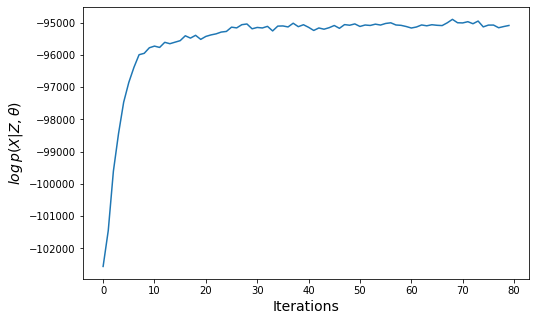

In [13]:
plt.figure(figsize=(8,5))
plt.plot(log_x_list)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('$log \, p(X|Z, \\theta)$', fontsize=14)
plt.show()

#### 1.6) Using your implementation of Algorithm 1, and the implementations of Algorithm 2 and 3 provided in the jupyter notebook, explain the differences in convergence speed of the algorithms in terms of number of iterations and time. What is the reason behind those differences?

##### Algorithm 2

In [14]:
def Z_XZTheta(X, Z, theta_matrix, alpha):
    N, I = X.shape
    K = theta_matrix.shape[0]
    z_probs = np.zeros([N, K])
    z_matrix = np.zeros([N, K])
    alpha_sum =  np.sum(alpha)
    z_sum = np.sum(Z, axis=0)
    lik_X =np.exp(X @ np.log(theta_matrix.T))
    for n in range(N):
        z_n =  Z[n, :]
        z_sum_n = z_sum - z_n
        zn_Z = (z_sum_n + alpha)/(N -1 + alpha_sum)
        z_probs_n_unnormalized = zn_Z * lik_X[n,:]
        z_probs_n = (z_probs_n_unnormalized / np.sum(z_probs_n_unnormalized)).flatten()

        z_n = np.random.multinomial(n=1, pvals=z_probs_n, size=1).flatten()

        z_probs[n, :] = z_probs_n
        z_matrix[n, :] = z_n
        z_sum = z_sum_n + z_n
    return z_probs, z_matrix

In [15]:
def fit_collapsed_pi(X, K, alpha, gamma, burn_in, n_iters):
    N, I = X.shape
    '''Initialize parameters'''
    pi_vector, theta_matrix, z_vector =  initialize_parameters(N, K, alpha, gamma)
    z_map = np.zeros([N, K])
    log_x_list = []

    for it in range(n_iters):
        '''Update parameters'''
        for k in range(K):
            theta_matrix[k, :] = thetak_XZ(X, z_vector, k, gamma)
        z_probs, z_vector = Z_XZTheta(X, z_vector, theta_matrix, alpha)
        '''Check log-likelihood'''
        log_lik_it = log_likelihood_X(X, z_vector, theta_matrix)
        log_x_list.append(log_lik_it)
        
        print('ITER: {} | log_lik: {}'.format(str(it), log_lik_it))
        if it > burn_in: z_map += z_vector
    
    Zk = np.argmax(z_map, axis=-1)
    z_map = np.zeros([N, K])
    for i in range(N):
        z_map[i, Zk[i]] = 1.
    
    return pi_vector, theta_matrix, z_vector, z_map, log_x_list

In [16]:
%%time
np.random.seed(1234)

alpha = 1.0*np.ones(K)
gamma = np.ones(I)

pi_vector, theta_matrix, z_vector, z_map, log_x_list = fit_collapsed_pi(X_matrix, K, alpha, gamma, 
                                                                        burn_in=20, n_iters=80)

ITER: 0 | log_lik: -102559.13775768132
ITER: 1 | log_lik: -101444.95518619668
ITER: 2 | log_lik: -99857.75052971399
ITER: 3 | log_lik: -98802.7255716796
ITER: 4 | log_lik: -97944.53712724333
ITER: 5 | log_lik: -97136.46440211793
ITER: 6 | log_lik: -96737.0270584693
ITER: 7 | log_lik: -96247.9295260658
ITER: 8 | log_lik: -95853.8223348138
ITER: 9 | log_lik: -95773.4511644731
ITER: 10 | log_lik: -95622.5144382543
ITER: 11 | log_lik: -95472.80112218104
ITER: 12 | log_lik: -95522.3921689912
ITER: 13 | log_lik: -95294.66412646817
ITER: 14 | log_lik: -95383.29082012144
ITER: 15 | log_lik: -95404.78467482804
ITER: 16 | log_lik: -95281.21739551745
ITER: 17 | log_lik: -95251.20506977575
ITER: 18 | log_lik: -95339.14271425702
ITER: 19 | log_lik: -95243.88874342805
ITER: 20 | log_lik: -95248.85468193541
ITER: 21 | log_lik: -95205.2077663973
ITER: 22 | log_lik: -95225.40937871636
ITER: 23 | log_lik: -95246.82557421472
ITER: 24 | log_lik: -95251.81580697169
ITER: 25 | log_lik: -95125.19286723336
IT

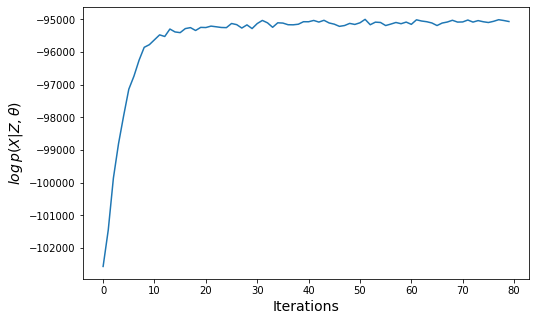

In [17]:
plt.figure(figsize=(8,5))
plt.plot(log_x_list)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('$log \, p(X|Z, \\theta)$', fontsize=14)
plt.show()

##### Algorithm 3

In [18]:
def beta_function(param_v):
    denominator = scipy.special.gamma(np.sum(param_v))
    print(denominator)
    numerator = np.prod([scipy.special.gamma(p) for p in param_v])
    return numerator / denominator

def ratio_beta_function(gamma, count_v):
    gamma = [int(g) for g in gamma.flatten()]
    count_v = [int(g) for g in count_v.flatten()]
    gamma_sum = np.sum(gamma)
    Wn = np.sum(count_v)
    num_terms = list()
    for gamma_m, count_m in zip(gamma, count_v):
        num_terms.append(np.prod([i for i in range(gamma_m, gamma_m + count_m)]))
    num = np.prod(num_terms)
    den = np.prod([j for j in range(gamma_sum, gamma_sum + Wn)])
    return num / den

def log_ratio_beta_function(gamma, count_v):
    gamma = gamma.flatten()
    gamma_sum = np.sum(gamma)
    Wn = int(np.sum(count_v))
    num_terms = list()
    for gamma_m, count_m in zip(gamma, count_v):
        if count_m == 0: continue
        term_m = list(map(lambda x: np.log(x + gamma_m), list(range(count_m))))
        num_terms.append(np.sum(term_m))
    num = np.sum(num_terms)
    den = np.sum([np.log(gamma_sum + j) for j in range(0, Wn)])
    out = num - den
    return out

In [19]:
def zn_Z_function(z_matrix, n, alpha):
    N = z_matrix.shape[0]
    z_matrix_n = np.delete(z_matrix, n, axis=0)
    count = np.sum(z_matrix_n, axis=0)
    numerator = count + alpha
    denominator = N - 1 + np.sum(alpha)
    return numerator / denominator

def gammak_p(z_matrix_n, x_matrix_n, k, gamma):
    z_k = (z_matrix_n[:, [k]].T == 1).flatten()
    gamma_p = gamma + np.sum(x_matrix_n[z_k, :], axis=0)  # [1, N-1] * [N-1, I]
    return gamma_p

def predictive_likelihood(z_matrix, X, n, gamma):
    N, K = z_matrix.shape
    z_matrix_n = np.delete(z_matrix, n, axis=0)
    count_nm = X[n, :]  # [1, I]
    x_matrix_n = np.delete(X, n, axis=0)
    predictive_lik = np.zeros(K)
    for k in range(K):
        gamma_p = gammak_p(z_matrix_n, x_matrix_n, k, gamma)
        predictive_lik[k] = np.exp(log_ratio_beta_function(gamma_p, count_nm))
    return predictive_lik

In [20]:
def fit_collapsed_pi_theta(X, K, alpha, gamma, burn_in, n_iters):
    N, I = X.shape
    X = X.astype(int)
    '''Initialize parameters'''
    pi_vector, theta_matrix, z_vector =  initialize_parameters(N, K, alpha, gamma)
    z_map = np.zeros([N, K])
    z_probs = np.zeros([N, K])
    log_x_list = []
    for it in range(n_iters):
        '''Update parameters'''        
        for n in range(N):
            zn_Z = zn_Z_function(z_vector, n, alpha)
            pred_lik = predictive_likelihood(z_vector, X, n, gamma)
            z_probs[n, :] = zn_Z * pred_lik / np.sum(zn_Z * pred_lik)
            z_vector[n, :] = np.random.multinomial(n=1, pvals=z_probs[n, :], size=1)
        for k in range(K):
            theta_matrix[k,:] = thetak_XZ(X, z_vector, k, gamma)
        '''Check log-likelihood'''
        log_lik_it = log_likelihood_X(X, z_vector, theta_matrix)
        log_x_list.append(log_lik_it)

        print('ITER: {} | log_lik: {}'.format(str(it), log_lik_it))

        if it > burn_in: z_map += z_vector
    
    Zk = np.argmax(z_map, axis=-1)
    z_map = np.zeros([N, K])
    for i in range(N):
        z_map[i, Zk[i]] = 1.
    
    return pi_vector, theta_matrix, z_vector, z_map, log_x_list

In [21]:
%%time
np.random.seed(1234)

alpha = 1*np.ones(K)
gamma = np.ones(I)

pi_vector, theta_matrix, z_vector, z_map, log_x_list = fit_collapsed_pi_theta(X_matrix, K, alpha, gamma, 
                                                                              burn_in=3, n_iters=5)

ITER: 0 | log_lik: -101250.93189820576
ITER: 1 | log_lik: -98993.18803052124
ITER: 2 | log_lik: -97736.05883526342
ITER: 3 | log_lik: -96814.40911466136
ITER: 4 | log_lik: -96141.63683382876
CPU times: user 1min 12s, sys: 12.8 s, total: 1min 25s
Wall time: 1min 20s


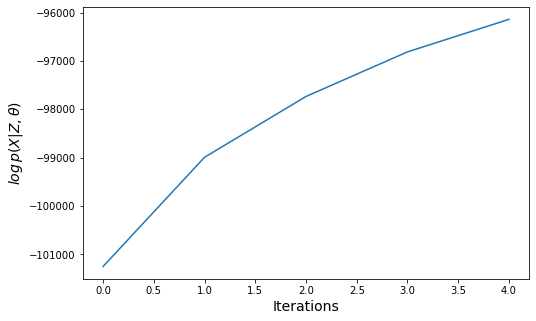

In [22]:
plt.figure(figsize=(8,5))
plt.plot(log_x_list)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('$log \, p(X|Z, \\theta)$', fontsize=14)
plt.show()